## Set-up

Import modules.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

## Data loading

Download the data.

In [77]:
!wget https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true

--2021-05-12 05:34:43--  https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz [following]
--2021-05-12 05:34:44--  https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz [following]
--2021-05-12 05:34:44--  https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.gi

Fetch the data.

In [78]:
!tar -xvf latestdata.tar.gz?raw=true

latestdata.csv


Load the data.

In [79]:
dataframe = pd.read_csv('latestdata.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data viewing

In [80]:
dataframe.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


In [81]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ID                        object 
 1   age                       object 
 2   sex                       object 
 3   city                      object 
 4   province                  object 
 5   country                   object 
 6   latitude                  float64
 7   longitude                 float64
 8   geo_resolution            object 
 9   date_onset_symptoms       object 
 10  date_admission_hospital   object 
 11  date_confirmation         object 
 12  symptoms                  object 
 13  lives_in_Wuhan            object 
 14  travel_history_dates      object 
 15  travel_history_location   object 
 16  reported_market_exposure  object 
 17  additional_information    object 
 18  chronic_disease_binary    bool   
 19  chronic_disease           object 
 20  source                  

In [82]:
dataframe.isnull().sum()

ID                                0
age                         2098293
sex                         2096154
city                         977681
province                     452664
country                         115
latitude                         61
longitude                        61
geo_resolution                   61
date_onset_symptoms         2414712
date_admission_hospital     2560100
date_confirmation            108489
symptoms                    2674259
lives_in_Wuhan              2671973
travel_history_dates        2673700
travel_history_location     2667089
reported_market_exposure    2675242
additional_information      2630456
chronic_disease_binary            0
chronic_disease             2676096
source                       566964
sequence_available          2676299
outcome                     2368929
date_death_or_discharge     2673163
notes_for_discussion        2675671
location                    2662935
admin3                      2595877
admin2                      

## Data cleaning and visualisation

Create a copy for exploration.

In [83]:
df = dataframe.copy()

### Visualise categorical data

In [84]:
def plot_categorical(col):
  col_count = df[col].value_counts()[:10]
  sns.barplot(x=col_count.index, y=col_count.values)
  plt.title('Frequency Distribution of ' + col)
  plt.ylabel('Number of Occurrences', fontsize=12)
  plt.xlabel(col)
  plt.xticks(rotation=75)

In [85]:
cols_lst = list(df.select_dtypes(include=[object]).columns)
cols_lst

['ID',
 'age',
 'sex',
 'city',
 'province',
 'country',
 'geo_resolution',
 'date_onset_symptoms',
 'date_admission_hospital',
 'date_confirmation',
 'symptoms',
 'lives_in_Wuhan',
 'travel_history_dates',
 'travel_history_location',
 'reported_market_exposure',
 'additional_information',
 'chronic_disease',
 'source',
 'sequence_available',
 'outcome',
 'date_death_or_discharge',
 'notes_for_discussion',
 'location',
 'admin3',
 'admin2',
 'admin1',
 'country_new',
 'data_moderator_initials',
 'travel_history_binary']

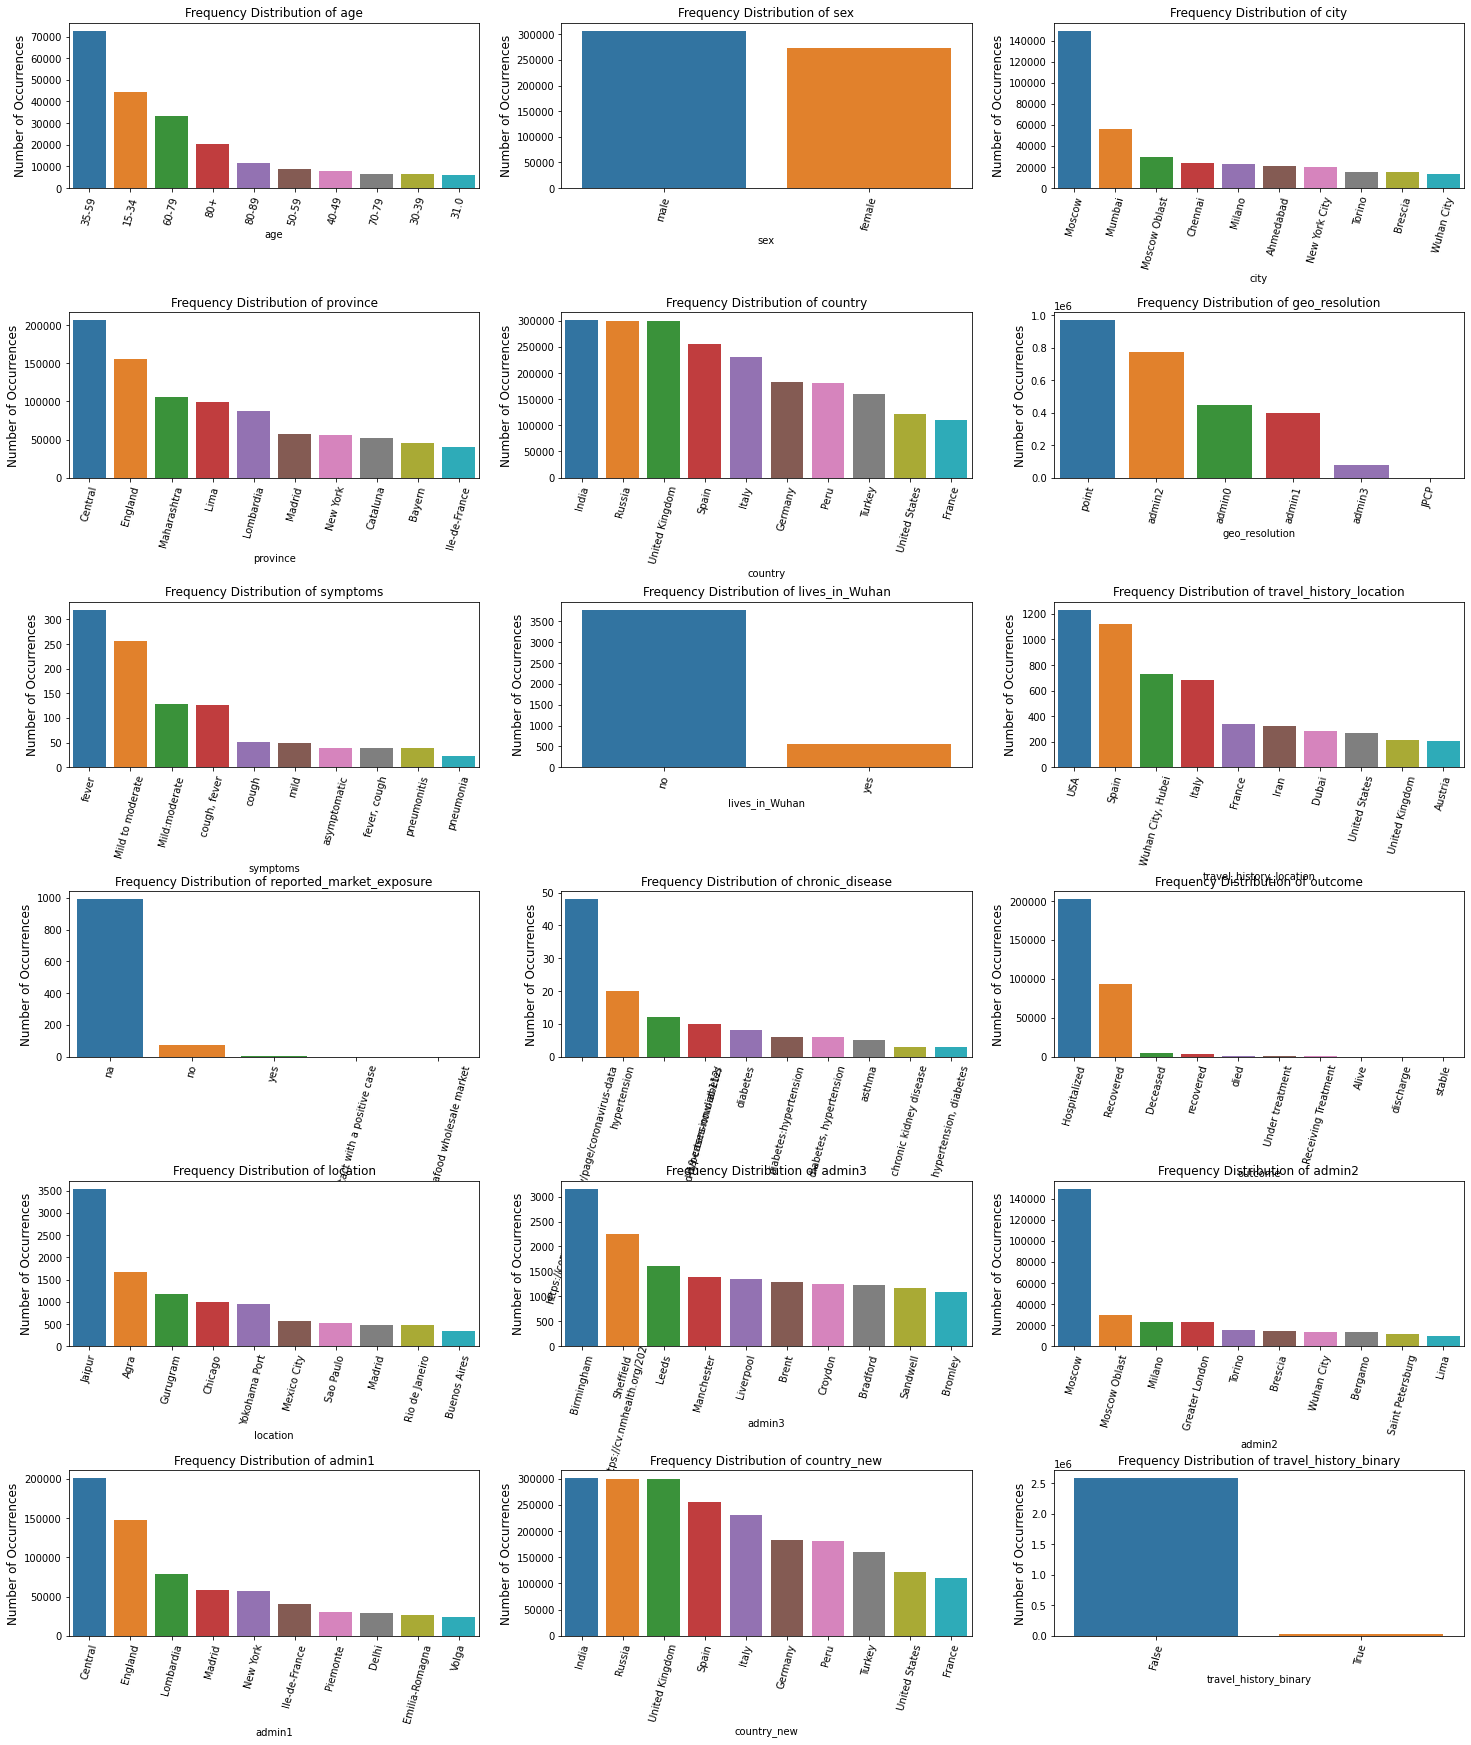

In [86]:
exclude = ['ID', 'date_onset_symptoms', 'date_admission_hospital', 
           'date_confirmation', 'travel_history_dates', 
           'additional_information', 'source', 'sequence_available', 
           'date_death_or_discharge', 'notes_for_discussion',
           'data_moderator_initials']
cols_lst = [col for col in cols_lst if col not in exclude]

n_cols = 3
n_rows = int(len(cols_lst)/n_cols) + 1 
plt.figure(figsize=(25, 5 * n_rows))
plt.tight_layout()

for i, col in enumerate(cols_lst, start=0):
  plt.subplot(n_rows,n_cols,i+1)
  plot_categorical(col)
  plt.subplots_adjust(hspace=0.75)
  

### Plot latitude and longitude

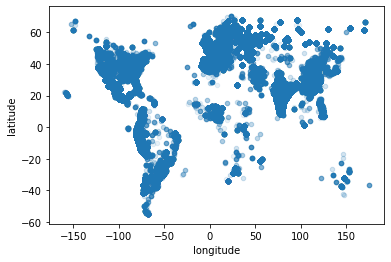

In [87]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

### Plot number of cases confirmed by time

**date_confirmation** – Date when the reported case was confirmed as having COVID-19 using rt-PCR. Confrmation accuracy is contingent on the data source used. Specifc dates are reported as DD.MM.YYYY.

Inspect 'date_confirmation' column

In [88]:
df['date_confirmation'].value_counts()

26.03.2020                 48319
27.03.2020                 43379
23.03.2020                 39288
06.05.2020                 38679
07.05.2020                 38606
                           ...  
17.01.2020                     2
12.03.2020-14.03.2020          2
06.03.2020 - 08.03.2020        2
16.01.2020                     2
15.01.2020                     2
Name: date_confirmation, Length: 178, dtype: int64

Identify no. entries with missing values

In [89]:
df.date_confirmation.isnull().sum()

108489

Remove entries with missing values

In [90]:
len_before = len(df)
print('no. entries before dropping missing values: ', len_before)
df = df.dropna(subset=['date_confirmation'])
len_after  = len(df) 
print('no. entries after dropping missing values:  ', len_after)
print('no. entries dropped:                        ', len_before - len_after)

no. entries before dropping missing values:  2676311
no. entries after dropping missing values:   2567822
no. entries dropped:                         108489


Try to identify entries not in the format 'DD.MM.YYYY'.

In [91]:
df['date_confirmation'][df.date_confirmation.str.len() != 10]

5556     25.02.2020 - 26.02.2020
12774    25.02.2020 - 26.02.2020
12779    25.02.2020 - 03.03.2020
12780    25.02.2020 - 03.03.2020
12781    25.02.2020 - 03.03.2020
                  ...           
36111    14.03.2020 - 16.03.2020
36112    14.03.2020 - 16.03.2020
36113    14.03.2020 - 16.03.2020
36114    14.03.2020 - 16.03.2020
36115    14.03.2020 - 16.03.2020
Name: date_confirmation, Length: 1975, dtype: object

Deal with entries not in the format 'DD.MM.YYYY'. (I chose to remove them.)

In [92]:
len_before = len(df)
print('no. entries before dropping wrongly-formatted values: ', len_before)
df = df[df.date_confirmation.str.len() == 10]
len_after  = len(df) 
print('no. entries after dropping wrongly-formatted values:  ', len_after)
print('no. entries dropped:                                  ', len_before - len_after)

no. entries before dropping wrongly-formatted values:  2567822
no. entries after dropping wrongly-formatted values:   2565847
no. entries dropped:                                   1975


Change 'date_confirmation' column data-type to 'datetime'.

In [93]:
dtype_before = df['date_confirmation'].dtype
print('dtype before: ', dtype_before)
df['date_confirmation'] = pd.to_datetime(df['date_confirmation'])
dtype_after = df['date_confirmation'].dtype
print('dtype after:  ', dtype_after)

dtype before:  object
dtype after:   datetime64[ns]


Sort cases by date confirmed.

In [94]:
print('data before sorting:')
print('--------------------')
print(df['date_confirmation'])
df = df.sort_values(by=['date_confirmation'])
print('\n')
print('data after sorting:')
print('--------------------')
print(df['date_confirmation'])

data before sorting:
--------------------
0         2020-02-14
1         2020-02-21
2         2020-02-14
3         2020-01-26
4         2020-02-14
             ...    
2676306   2020-05-17
2676307   2020-05-17
2676308   2020-05-17
2676309   2020-05-17
2676310   2020-05-17
Name: date_confirmation, Length: 2565847, dtype: datetime64[ns]


data after sorting:
--------------------
61096     2020-01-02
61125     2020-01-02
61124     2020-01-02
61123     2020-01-02
61122     2020-01-02
             ...    
2329423   2020-12-06
2329424   2020-12-06
2329425   2020-12-06
2329418   2020-12-06
2328578   2020-12-06
Name: date_confirmation, Length: 2565847, dtype: datetime64[ns]


Plot number of cases confirmed by date.

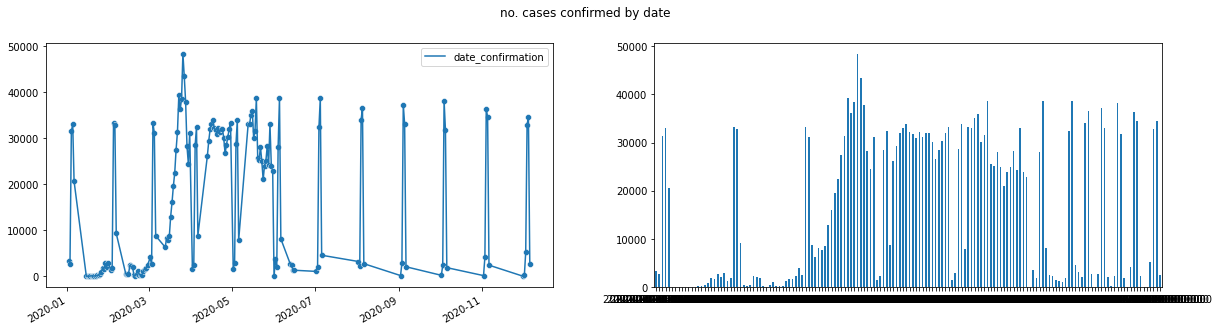

In [95]:
daycount = df['date_confirmation'].value_counts()
daycount = daycount.sort_index()

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
daycount.plot()
sns.scatterplot(x=daycount.index, y=daycount.values)
plt.suptitle('no. cases confirmed by date')

plt.subplot(1, 2, 2)
plt.xticks([])
daycount.plot(kind='bar')
plt.show()

Investigate behaviour of graph by viewing $n$ entries with the highest frequency.

In [96]:
n=20
f = df['date_confirmation'].value_counts()[:n].index.tolist()
f

[Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-03-27 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-06-05 00:00:00'),
 Timestamp('2020-07-05 00:00:00'),
 Timestamp('2020-05-19 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-10-04 00:00:00'),
 Timestamp('2020-03-28 00:00:00'),
 Timestamp('2020-09-04 00:00:00'),
 Timestamp('2020-08-05 00:00:00'),
 Timestamp('2020-11-04 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-05-16 00:00:00'),
 Timestamp('2020-05-15 00:00:00'),
 Timestamp('2020-12-05 00:00:00'),
 Timestamp('2020-11-05 00:00:00'),
 Timestamp('2020-08-04 00:00:00'),
 Timestamp('2020-05-05 00:00:00'),
 Timestamp('2020-04-17 00:00:00')]

Plot number of cases confirmed by month.

no. cases by month:
-------------------------
date_confirmation
1     104745
2      96324
3     567853
4     630918
5     618133
6      88290
7      78579
8      78538
9      75291
10     74229
11     77554
12     75393
Name: date_confirmation, dtype: int64




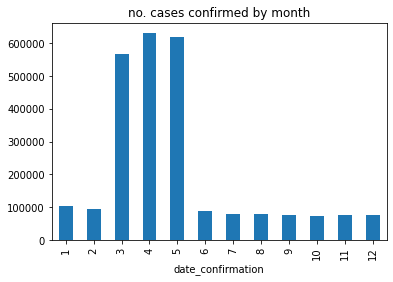

In [97]:
monthcount = df['date_confirmation'].groupby(df['date_confirmation'].dt.month).agg('count')
print('no. cases by month:')
print('-------------------------')
print(monthcount)
print('\n')
monthcount.plot(kind='bar')
plt.title('no. cases confirmed by month')
plt.show()

Create functions for plotting cases by time.

In [98]:
def plot_by_date(dataframe, show_title=False, kind='line'):
  dataframe = dataframe.sort_values(by=['date_confirmation'])
  count = dataframe['date_confirmation'].value_counts()
  if kind == 'bar':
    plt.xticks([])
    count.sort_index().plot(kind='bar')
  else:
    count.plot()
    sns.scatterplot(x=count.index, y=count.values)
  if show_title:
    plt.title('no. cases confirmed by date')

def plot_by_month(dataframe, kind='bar'):
  count = dataframe['date_confirmation'].groupby(dataframe['date_confirmation'].dt.month).agg('count')
  count.plot(kind=kind)
  plt.title('no. cases confirmed by month')

def plot_by_week(dataframe, kind='bar'):
  count = dataframe['date_confirmation'].groupby(dataframe['date_confirmation'].dt.isocalendar().week).agg('count')
  count.plot(kind=kind)
  plt.title('no. cases confirmed by week')

### Plot number of cases confirmed by country

**country** – Name of country in which the case is reported. Note that imported cases will be assigned to the country in which confrmation occurred - this is typically in the arrival country, rather than the site of infection. “Travel_history_location” will describe other locations of travel for such instances.

**country_new** – Administrative unit level 0 (e.g., country) of where the case was reported.

Inspect 'country' and 'country_new' columns.


In [99]:
print('country counts:')
print('---------------')
print(df['country'].value_counts())
print('\n')
print('country_new counts:')
print('-------------------')
print(df['country_new'].value_counts())

country counts:
---------------
India                               301207
Russia                              299568
United Kingdom                      299469
Spain                               255108
Italy                               231006
                                     ...  
Gibraltar                                1
Andorra                                  1
Lithuania                                1
Malta                                    1
Saint Vincent and the Grenadines         1
Name: country, Length: 146, dtype: int64


country_new counts:
-------------------
India             301207
Russia            299568
United Kingdom    299469
Spain             255108
Italy             231006
                   ...  
Gibraltar              1
Bolivia                1
Latvia                 1
Lithuania              1
Malta                  1
Name: country_new, Length: 144, dtype: int64


Drop 'country_new' column because it is near-identical to 'country'.

In [100]:
len_before = len(df.columns)
print('df len before dropping column: ', len_before)
df = df.drop(columns='country_new')
len_after = len(df.columns)
print('df len after dropping column:  ', len_after)

df len before dropping column:  33
df len after dropping column:   32


Identify no. entries with missing values

In [101]:
print('no. entries with missing values:', df.country.isnull().sum())

no. entries with missing values: 55


Remove entries with missing values.

In [102]:
len_before = len(df)
print('no. entries before dropping missing values: ', len_before)
df = df.dropna(subset=['country'])
len_after  = len(df) 
print('no. entries after dropping missing values:  ', len_after)
print('no. entries dropped:                        ', len_before - len_after)

no. entries before dropping missing values:  2565847
no. entries after dropping missing values:   2565792
no. entries dropped:                         55


Create new dataframe for data in India.

In [103]:
df_India = df[df['country'] == 'India']
len(df_India['country'])

301207

Plot number of cases confirmed in India by date.

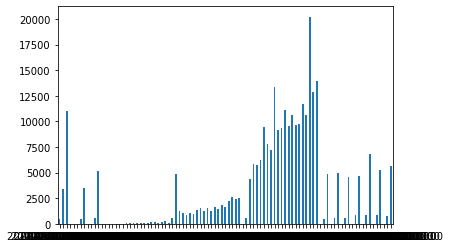

In [104]:
plot_by_date(df_India, kind='bar')

Plot number of cases confirmed in India by month.

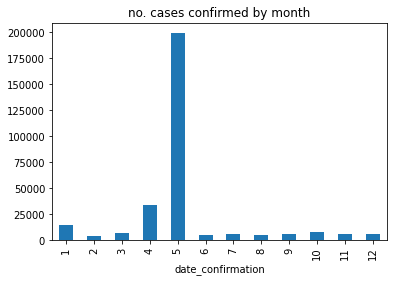

In [105]:
plot_by_month(df_India)

Create function to plot number of cases confirmed in a country by date.

In [106]:
def plot_by_country(dataframe, country, kind='line'):
  dataframe = dataframe[dataframe['country'] == country]
  plot_by_date(dataframe, kind=kind)

### Plot number of cases confirmed by country for selected countries

Obtain list of unique countries.

In [107]:
countries = df['country'].unique()
print('no. unique countries: ', len(countries))
print(countries)

no. unique countries:  146
['China' 'Philippines' 'United Arab Emirates' 'Japan' 'Australia'
 'Singapore' 'United States' 'South Korea' 'Iran' 'Ecuador' 'Qatar'
 'Switzerland' 'Kuwait' 'Italy' 'Canada' 'Israel' 'Germany' 'Armenia'
 'Bahrain' 'Egypt' 'United Kingdom' 'Luxembourg' 'Finland' 'Belgium'
 'Croatia' 'Norway' 'Czech Republic' 'Austria' 'Netherlands' 'Iceland'
 'Sweden' 'Spain' 'Turkey' 'Ukraine' 'Nigeria' 'Montenegro' 'India'
 'Bosnia and Herzegovina' 'Colombia' 'Peru' 'Hungary' 'Serbia' 'Albania'
 'Slovakia' 'Argentina' 'Russia' 'Kenya' 'Algeria' 'Slovenia' 'Moldova'
 'Paraguay' 'Estonia' 'South Africa' 'Ireland' 'Mexico' 'Cuba' 'Uruguay'
 'North Macedonia' 'Guatemala' 'Ghana' 'Bahamas' 'Ethiopia' 'Belarus'
 'Thailand' 'Vietnam' 'Nepal' 'France' 'Malaysia' 'Sri Lanka' 'Cambodia'
 'Iraq' 'Tunisia' 'Jordan' 'Senegal' 'Morocco' 'Lebanon' 'Portugal'
 'Brazil' 'Latvia' 'Saudi Arabia' 'Andorra' 'Pakistan' 'Liechtenstein'
 'Niger' 'Zimbabwe' 'Afghanistan' 'Oman' 'Romania' 'Georgia' 

Plot number of cases confirmed by country for selected countries.

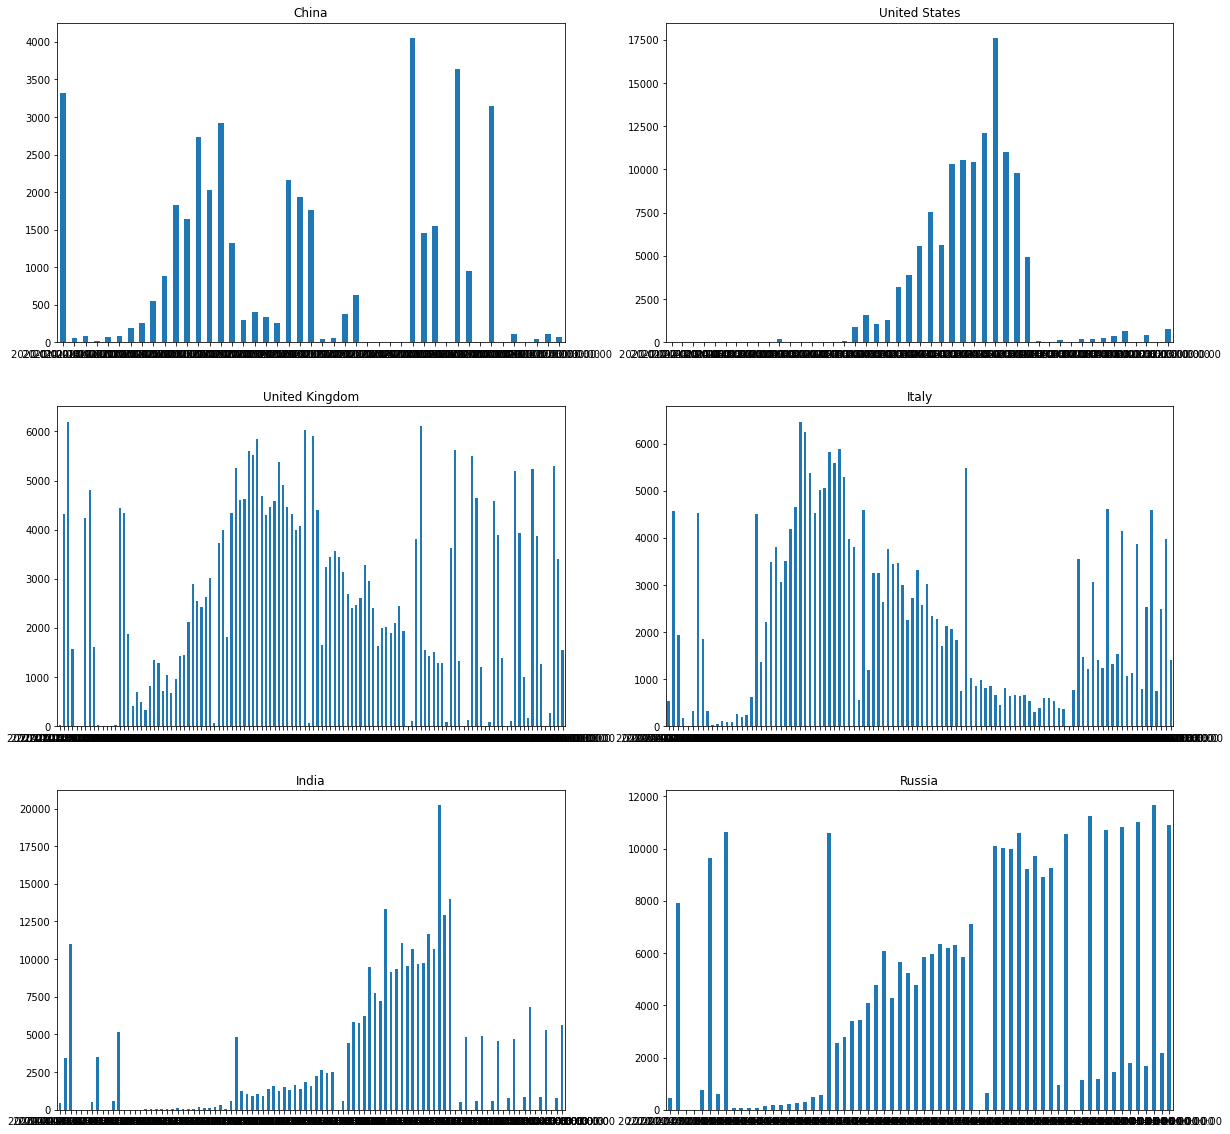

In [108]:
plt.figure(figsize=(20,20))
for i, country in enumerate(['China', 'United States', 'United Kingdom', 'Italy', 'India', 'Russia']):
  plt.subplot(3,2,i+1)
  plot_by_country(df, country, kind='bar')
  plt.title(country)

### Plot number cases confirmed by age range

Inspect 'age' column.

In [109]:
df['age'].value_counts()[:20]

35-59    72775
15-34    44573
60-79    33074
80+      20203
80-89    11467
50-59     8987
40-49     7690
70-79     6676
30-39     6304
31.0      6090
60-69     6047
90+       5972
32.0      5888
33.0      5686
30.0      5657
29.0      5656
37.0      5644
35.0      5637
28.0      5595
38.0      5554
Name: age, dtype: int64

Run tests before cleaning.

In [110]:
print(len(df[df['age'] == '16-80']))
a = df['age'][407242]
print(a, a.isnumeric())
b = df['age'][14442]
print(b, b.isnumeric())
print(a[:2] == '16')
print(b[:2] == '44')
c = 32
print(b in [44])
d = 3.0
# print(d.isnumeric()) -- returns AttributeError: 'float' object has no attribute 'isnumeric'
print(isinstance(a, str))

print('before replacement: ', b)
# df['age'][14442] = '44' -- returns A value is trying to be set on a copy of a slice from a DataFrame
df.at[14442, 'age'] = '35-59'
print('after replacement:  ', df['age'][14442])

68
16-80 False
44 True
True
True
False
True
before replacement:  44
after replacement:   35-59


Clean 'age' data so that they fall under one of: `0-14`, `15-34`, `35-59`, `60-79`, or `80+`.

In [111]:
for item, frame in df['age'].iteritems():
  if pd.notnull(frame): 
    if str(frame).isnumeric() or isinstance(frame, float):
      i = int(frame)
      if i < 15:
        # print(item, frame, '0-14')
        df.at[item, 'age'] = '0-14'
        # print(item, df['age'][item])
      elif i < 35:
        # print(item, frame, '15-34')
        df.at[item, 'age'] = '15-34'
        # print(item, df['age'][item])
      elif i < 60:
        # print(item, frame, '35-59')
        df.at[item, 'age'] = '35-59'
        # print(item, df['age'][item])
      elif i < 80:
        # print(item, frame, '60-79')
        df.at[item, 'age'] = '60-79'
        # print(item, df['age'][item])
      else:
        # print(item, frame, '80+')
        df.at[item, 'age'] = '80+'
        # print(item, df['age'][item])
    elif 'month' in str(frame):
      print(item, frame)

614363 18 months
614508 18 month
614514 7 months
614565 4 months
615340 6 months
615448 9 month
615465 5 month
615569 8 month
615946 11 month
614976 18 month
614975 13 month
614985 5 months
615131 8 month


In [112]:
df['age'].value_counts()

35-59        227335
15-34        156545
60-79         80406
80+           29001
0-14          15478
              ...  
0.4               1
11-12             1
18 months         1
54.9              1
23-24             1
Name: age, Length: 174, dtype: int64

### Group outcomes as either 'died' or 'discharged'

In [113]:
df['outcome'].value_counts()

Hospitalized                                                                202475
Recovered                                                                    93656
Deceased                                                                      5010
recovered                                                                     3659
died                                                                           879
Under treatment                                                                370
Receiving Treatment                                                            257
Alive                                                                          186
discharge                                                                      175
stable                                                                         156
stable condition                                                               133
https://www.mspbs.gov.py/covid-19.php                                          126
disc

In [114]:
print('died' == 'Died')
print('died' == 'Died'.lower())
print('decease' in 'Deceased'.lower())

False
True
True


In [115]:
died_list = ['Deceased', 'died', 'death', 'Dead', 'Death', 'Died', 'dead']
discharged_list = ['Recovered', 'recovered', 'discharge', 'discharged', 
                   'Discharged from hospital', 'Discharged']

In [116]:
print(len(df[df['outcome'].isin(died_list)]))
print(len(df[df['outcome'].isin(discharged_list)]))
print(len(df[df['outcome'].isin(died_list + discharged_list)]))

5955
97609
103564


In [117]:
df_outcome = df[df['outcome'].isin(died_list + discharged_list)]
df_outcome.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,admin_id,data_moderator_initials,travel_history_binary
14442,000-1-23,35-59,male,Manila,National Capital Region (NCR),Philippines,14.595800,120.9772,point,NaN,NaN,2020-01-02,"cough, sore throat",yes,NaN,"Wuhan City, Hubei",NaN,Travelled with other Philippines case; rravele...,True,"""thought to have had other pre-existing condit...",https://www.rappler.com/nation/250781-doh-seco...,NaN,died,01.02.2020,NaN,Manila,NaN,NaN,National Capital Region (NCR),5915.0,NaN,NaN
5557,000-1-150,60-79,female,Adelaide,South Australia,Australia,-34.928900,138.6011,admin2,NaN,NaN,2020-01-02,NaN,yes,21.01.2020,"Wuhan City, Hubei",NaN,NaN,False,NaN,https://www.abc.net.au/news/2020-02-01/coronav...,NaN,discharged,14.02.2020,NaN,NaN,NaN,Adelaide,South Australia,991.0,NaN,NaN
5445,000-1-149,60-79,male,Adelaide,South Australia,Australia,-34.928900,138.6011,admin2,NaN,NaN,2020-01-02,NaN,yes,21.01.2020,"Wuhan City, Hubei",NaN,NaN,False,NaN,https://www.abc.net.au/news/2020-02-01/coronav...,NaN,discharged,14.02.2020,NaN,NaN,NaN,Adelaide,South Australia,991.0,NaN,NaN
40063,000-1-61,15-34,female,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.8472,point,30.01.2020,31.01.2020,2020-01-02,NaN,NaN,22.01.2020,"Wuhan City, Hubei",NaN,Case 18; travel companion of case 12,False,NaN,https://www.moh.gov.sg/news-highlights/details...,NaN,discharge,27.02.2020,NaN,National Centre for Infectious Diseases,NaN,NaN,NaN,6480.0,NaN,NaN
410497,002-5258,15-34,female,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.8472,point,30.01.2020,31.01.2020,2020-01-02,NaN,NaN,22.01.2020,"Wuhan City, Hubei",NaN,Case 18; travel companion of case 12,False,NaN,https://www.moh.gov.sg/news-highlights/details...,NaN,discharge,27.02.2020,NaN,National Centre for Infectious Diseases,NaN,NaN,NaN,6480.0,NaN,True


In [118]:
df_outcome.isnull().sum()

ID                               0
age                          98149
sex                          96920
city                         14060
province                       359
country                          0
latitude                         0
longitude                        0
geo_resolution                   0
date_onset_symptoms         100119
date_admission_hospital     103358
date_confirmation                0
symptoms                    103394
lives_in_Wuhan              103439
travel_history_dates        103416
travel_history_location     103248
reported_market_exposure    103549
additional_information       96986
chronic_disease_binary           0
chronic_disease             103462
source                        9200
sequence_available          103562
outcome                          0
date_death_or_discharge     102419
notes_for_discussion        103536
location                    100844
admin3                      103545
admin2                      103366
admin1              

In [119]:
df_outcome.duplicated().value_counts()

False    103564
dtype: int64

In [120]:
print(len(df_outcome[df_outcome['date_onset_symptoms'].notnull()]))
print(len(df_outcome[df_outcome['date_onset_symptoms'].notnull() | df_outcome['symptoms'].notnull()]))

3445
3536


In [121]:
df_outcome_with_symptoms = df_outcome[df_outcome['date_onset_symptoms'].notnull() | df_outcome['symptoms'].notnull()]
df_outcome_with_symptoms.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,admin_id,data_moderator_initials,travel_history_binary
14442,000-1-23,35-59,male,Manila,National Capital Region (NCR),Philippines,14.595800,120.977200,point,NaN,NaN,2020-01-02,"cough, sore throat",yes,NaN,"Wuhan City, Hubei",NaN,Travelled with other Philippines case; rravele...,True,"""thought to have had other pre-existing condit...",https://www.rappler.com/nation/250781-doh-seco...,NaN,died,01.02.2020,NaN,Manila,NaN,NaN,National Capital Region (NCR),5915.0,NaN,NaN
40063,000-1-61,15-34,female,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.847200,point,30.01.2020,31.01.2020,2020-01-02,NaN,NaN,22.01.2020,"Wuhan City, Hubei",NaN,Case 18; travel companion of case 12,False,NaN,https://www.moh.gov.sg/news-highlights/details...,NaN,discharge,27.02.2020,NaN,National Centre for Infectious Diseases,NaN,NaN,NaN,6480.0,NaN,NaN
410497,002-5258,15-34,female,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.847200,point,30.01.2020,31.01.2020,2020-01-02,NaN,NaN,22.01.2020,"Wuhan City, Hubei",NaN,Case 18; travel companion of case 12,False,NaN,https://www.moh.gov.sg/news-highlights/details...,NaN,discharge,27.02.2020,NaN,National Centre for Infectious Diseases,NaN,NaN,NaN,6480.0,NaN,True
410187,002-5230,35-59,male,Manila,National Capital Region (NCR),Philippines,14.595800,120.977200,point,NaN,NaN,2020-01-02,"cough, sore throat",yes,NaN,"Wuhan City, Hubei; Hong Kong, China",NaN,Travelled with other Philippines case; death r...,True,"""thought to have had other pre-existing condit...",https://www.rappler.com/nation/250781-doh-seco...,NaN,died,01.02.2020,NaN,Manila,NaN,NaN,National Capital Region (NCR),5915.0,NaN,True
2557,000-1-123,60-79,female,Tan Tock Seng Hospital,NaN,Singapore,1.321611,103.845944,point,16.02.2020,27.02.2020,2020-01-03,NaN,no,14.02.2020,"Jakarta, Indonesia",NaN,Case 107,False,NaN,https://www.moh.gov.sg/news-highlights/details...,NaN,discharge,06.03.2020,NaN,NaN,NaN,NaN,NaN,8494.0,NaN,NaN


In [122]:
df_outcome_with_symptoms['age'].value_counts()

35-59    1409
15-34    1010
60-79     908
80+       128
0-14       62
80-89       4
0.25        2
20-29       2
50-59       2
Name: age, dtype: int64

In [123]:
df_outcome_with_symptoms.isnull().sum()

ID                             0
age                            9
sex                            1
city                          90
province                     174
country                        0
latitude                       0
longitude                      0
geo_resolution                 0
date_onset_symptoms           91
date_admission_hospital     3377
date_confirmation              0
symptoms                    3366
lives_in_Wuhan              3447
travel_history_dates        3462
travel_history_location     3421
reported_market_exposure    3521
additional_information        29
chronic_disease_binary         0
chronic_disease             3440
source                        48
sequence_available          3534
outcome                        0
date_death_or_discharge     2688
notes_for_discussion        3525
location                    3415
admin3                      3525
admin2                      3472
admin1                      3426
admin_id                       0
data_moder

In [124]:
df_outcome_attributes = df_outcome[['age', 'sex', 'country', 
'latitude', 'longitude', 'date_onset_symptoms', 'date_confirmation', 
'symptoms', 'chronic_disease_binary', 'outcome', 'travel_history_binary']]
df_outcome_attributes.head()

,age,sex,country,latitude,longitude,date_onset_symptoms,date_confirmation,symptoms,chronic_disease_binary,outcome,travel_history_binary
14442,35-59,male,Philippines,14.595800,120.9772,NaN,2020-01-02,"cough, sore throat",True,died,NaN
5557,60-79,female,Australia,-34.928900,138.6011,NaN,2020-01-02,NaN,False,discharged,NaN
5445,60-79,male,Australia,-34.928900,138.6011,NaN,2020-01-02,NaN,False,discharged,NaN
40063,15-34,female,Singapore,1.322098,103.8472,30.01.2020,2020-01-02,NaN,False,discharge,NaN
410497,15-34,female,Singapore,1.322098,103.8472,30.01.2020,2020-01-02,NaN,False,discharge,True


In [125]:
df_outcome_attributes.isnull().sum()

age                        98149
sex                        96920
country                        0
latitude                       0
longitude                      0
date_onset_symptoms       100119
date_confirmation              0
symptoms                  103394
chronic_disease_binary         0
outcome                        0
travel_history_binary        197
dtype: int64

In [126]:
print(len(df_outcome[df_outcome['date_onset_symptoms'].notnull() | df_outcome['symptoms'].notnull()]))

3536


In [127]:
df_outcome_attributes['symptoms_binary'] = np.where(
    df_outcome['date_onset_symptoms'].notnull() | 
    df_outcome['symptoms'].notnull(), True, False)
df_outcome_attributes.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,age,sex,country,latitude,longitude,date_onset_symptoms,date_confirmation,symptoms,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary
14442,35-59,male,Philippines,14.595800,120.9772,NaN,2020-01-02,"cough, sore throat",True,died,NaN,True
5557,60-79,female,Australia,-34.928900,138.6011,NaN,2020-01-02,NaN,False,discharged,NaN,False
5445,60-79,male,Australia,-34.928900,138.6011,NaN,2020-01-02,NaN,False,discharged,NaN,False
40063,15-34,female,Singapore,1.322098,103.8472,30.01.2020,2020-01-02,NaN,False,discharge,NaN,True
410497,15-34,female,Singapore,1.322098,103.8472,30.01.2020,2020-01-02,NaN,False,discharge,True,True


In [128]:
df_outcome_attributes.isnull().sum()

age                        98149
sex                        96920
country                        0
latitude                       0
longitude                      0
date_onset_symptoms       100119
date_confirmation              0
symptoms                  103394
chronic_disease_binary         0
outcome                        0
travel_history_binary        197
symptoms_binary                0
dtype: int64

In [129]:
df_outcome_attributes = df_outcome_attributes.drop(columns=['date_onset_symptoms', 'symptoms'])
df_outcome_attributes.head()

,age,sex,country,latitude,longitude,date_confirmation,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary
14442,35-59,male,Philippines,14.595800,120.9772,2020-01-02,True,died,NaN,True
5557,60-79,female,Australia,-34.928900,138.6011,2020-01-02,False,discharged,NaN,False
5445,60-79,male,Australia,-34.928900,138.6011,2020-01-02,False,discharged,NaN,False
40063,15-34,female,Singapore,1.322098,103.8472,2020-01-02,False,discharge,NaN,True
410497,15-34,female,Singapore,1.322098,103.8472,2020-01-02,False,discharge,True,True


In [130]:
df_outcome_attributes.isnull().sum()

age                       98149
sex                       96920
country                       0
latitude                      0
longitude                     0
date_confirmation             0
chronic_disease_binary        0
outcome                       0
travel_history_binary       197
symptoms_binary               0
dtype: int64

In [131]:
df_outcome_attributes = df_outcome_attributes.dropna()
df_outcome_attributes.head()

,age,sex,country,latitude,longitude,date_confirmation,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary
410497,15-34,female,Singapore,1.322098,103.8472,2020-01-02,False,discharge,True,True
410209,60-79,male,Australia,-34.928900,138.6011,2020-01-02,False,discharged,True,False
410187,35-59,male,Philippines,14.595800,120.9772,2020-01-02,True,died,True,True
410220,60-79,female,Australia,-34.928900,138.6011,2020-01-02,False,discharged,True,False
638877,50-59,male,United States,47.609720,-122.3330,2020-01-03,False,death,False,False


In [132]:
df_outcome_attributes['age'].value_counts()

35-59    2082
15-34    1498
60-79    1302
80+       180
0-14      115
80-89       8
70-79       7
50-59       5
20-29       3
90-99       2
60-69       1
0.5         1
80-         1
0.25        1
Name: age, dtype: int64

In [133]:
for item, frame in df_outcome_attributes['age'].iteritems():
  if frame in ['80-89', '90-99', '80-']:
    df_outcome_attributes.at[item, 'age'] = '80+'
  elif frame in ['70-79', '60-69']:
    df_outcome_attributes.at[item, 'age'] = '60-79'
  elif frame in ['50-59']:
    df_outcome_attributes.at[item, 'age'] = '35-59'
  elif frame in ['20-29']:
    df_outcome_attributes.at[item, 'age'] = '15-34'
  elif frame == '0.5' or frame == '0.25':
    df_outcome_attributes.at[item, 'age'] = '0-14'

In [134]:
df_outcome_attributes['age'].value_counts()

35-59    2087
15-34    1501
60-79    1310
80+       191
0-14      117
Name: age, dtype: int64

In [135]:
df_outcome_attributes = df_outcome_attributes.drop(columns='country')
df_outcome_attributes

,age,sex,latitude,longitude,date_confirmation,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary
410497,15-34,female,1.322098,103.84720,2020-01-02,False,discharge,True,True
410209,60-79,male,-34.928900,138.60110,2020-01-02,False,discharged,True,False
410187,35-59,male,14.595800,120.97720,2020-01-02,True,died,True,True
410220,60-79,female,-34.928900,138.60110,2020-01-02,False,discharged,True,False
638877,35-59,male,47.609720,-122.33300,2020-01-03,False,death,False,False
...,...,...,...,...,...,...,...,...,...
122778,15-34,male,12.520580,121.43955,2020-12-05,False,recovered,False,True
122776,35-59,male,10.705070,122.56785,2020-12-05,False,recovered,False,False
122775,15-34,female,14.630000,121.03000,2020-12-05,False,recovered,False,True
122753,60-79,female,14.450000,120.98000,2020-12-05,False,recovered,False,True


In [136]:
df_outcome_attributes = df_outcome_attributes.drop(columns='date_confirmation')
df_outcome_attributes.head()

,age,sex,latitude,longitude,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary
410497,15-34,female,1.322098,103.8472,False,discharge,True,True
410209,60-79,male,-34.928900,138.6011,False,discharged,True,False
410187,35-59,male,14.595800,120.9772,True,died,True,True
410220,60-79,female,-34.928900,138.6011,False,discharged,True,False
638877,35-59,male,47.609720,-122.3330,False,death,False,False


## Data cleaning (2)

In [137]:
df = df_outcome_attributes.copy()
df.head()

,age,sex,latitude,longitude,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary
410497,15-34,female,1.322098,103.8472,False,discharge,True,True
410209,60-79,male,-34.928900,138.6011,False,discharged,True,False
410187,35-59,male,14.595800,120.9772,True,died,True,True
410220,60-79,female,-34.928900,138.6011,False,discharged,True,False
638877,35-59,male,47.609720,-122.3330,False,death,False,False


In [138]:
print('Before:')
print(df['outcome'].value_counts())
df.loc[df['outcome'].isin(died_list), 'outcome'] = 'died'
df.loc[df['outcome'].isin(discharged_list), 'outcome'] = 'discharged'
print()
print('After:')
print(df['outcome'].value_counts())

Before:
recovered     3651
died           852
Deceased       398
Recovered      139
discharge       78
discharged      51
death           25
Dead             6
Death            3
dead             2
Died             1
Name: outcome, dtype: int64

After:
discharged    3919
died          1287
Name: outcome, dtype: int64


## Data transformation

### Transforming numerical data

In [139]:
num_attribs = ['latitude', 'longitude']

print('Before')
print('-----------------')
print('mean')
print(df[num_attribs].mean())
print('\n' + 'std')
print(df[num_attribs].std())

scaler = StandardScaler()

df[num_attribs] = scaler.fit_transform(df[num_attribs])

print()
print('After')
print('-----------------')
print('mean')
print(df[num_attribs].mean())
print('\n' + 'std')
print(df[num_attribs].std())

Before
-----------------
mean
latitude      14.441598
longitude    114.813316
dtype: float64

std
latitude      5.137918
longitude    23.035944
dtype: float64

After
-----------------
mean
latitude    -1.226429e-16
longitude   -1.199578e-15
dtype: float64

std
latitude     1.000096
longitude    1.000096
dtype: float64


### Transforming categorical data

In [140]:
cat_attribs = ['age', 'sex']

encoder = OneHotEncoder()

dense_array_1hot = encoder.fit_transform(df[cat_attribs]).todense()

columns_1hot = encoder.get_feature_names(cat_attribs)
print('columns_1hot:', columns_1hot)

df_1hot = pd.DataFrame(dense_array_1hot, columns=columns_1hot)
print(df_1hot.head())

columns_1hot: ['age_0-14' 'age_15-34' 'age_35-59' 'age_60-79' 'age_80+' 'sex_female'
 'sex_male']
   age_0-14  age_15-34  age_35-59  age_60-79  age_80+  sex_female  sex_male
0       0.0        1.0        0.0        0.0      0.0         1.0       0.0
1       0.0        0.0        0.0        1.0      0.0         0.0       1.0
2       0.0        0.0        1.0        0.0      0.0         0.0       1.0
3       0.0        0.0        0.0        1.0      0.0         1.0       0.0
4       0.0        0.0        1.0        0.0      0.0         0.0       1.0


In [141]:
df_prepared = pd.concat([df.reset_index(), df_1hot], axis=1).drop(columns=['index', 'age', 'sex'])
df_prepared.head()

,latitude,longitude,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary,age_0-14,age_15-34,age_35-59,age_60-79,age_80+,sex_female,sex_male
0,-2.553711,-0.476089,False,discharged,True,True,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-9.609970,1.032737,False,discharged,True,False,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.030015,0.267603,True,died,True,True,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-9.609970,1.032737,False,discharged,True,False,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,6.456177,-10.295610,False,died,False,False,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Transform labels

In [142]:
# 1 is discharged, 0 is died
df_prepared['outcome'] = LabelBinarizer().fit_transform(df_prepared['outcome'])
df_prepared.head()

,latitude,longitude,chronic_disease_binary,outcome,travel_history_binary,symptoms_binary,age_0-14,age_15-34,age_35-59,age_60-79,age_80+,sex_female,sex_male
0,-2.553711,-0.476089,False,1,True,True,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-9.609970,1.032737,False,1,True,False,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.030015,0.267603,True,0,True,True,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-9.609970,1.032737,False,1,True,False,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,6.456177,-10.295610,False,0,False,False,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [143]:
df_prepared['outcome'].head()

0    1
1    1
2    0
3    1
4    0
Name: outcome, dtype: int64

## Data splitting

In [144]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X=df_prepared, y=df_prepared['chronic_disease_binary']):
    train_set = df_prepared.loc[train_index]
    test_set = df_prepared.loc[test_index]

print(train_set.shape)
print(train_set['chronic_disease_binary'].value_counts() / len(train_set))
print()
print(test_set.shape)
print(test_set['chronic_disease_binary'].value_counts() / len(test_set))

(4164, 13)
False    0.981988
True     0.018012
Name: chronic_disease_binary, dtype: float64

(1042, 13)
False    0.981766
True     0.018234
Name: chronic_disease_binary, dtype: float64


In [145]:
X_train = train_set.drop('outcome', axis=1)
y_train = train_set['outcome'].copy()
X_test = test_set.drop('outcome', axis=1)
y_test = test_set['outcome'].copy()

In [146]:
# code from the practical Exercise for Logistic Regression

print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)

val_cnts = y_train.value_counts()
print("Class distribution of positive and negative samples in the train set:")
print(val_cnts)
print("Percentage of positive class samples: %s" % "%2f%%" % (100 * val_cnts[1] / len(y_train)))

print("---")
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

val_cnts = y_test.value_counts()
print("Class distribution of positive and negative samples in the test set:")
print(val_cnts)
print("Percentage of positive class samples: %s" % "%2f%%" % (100 * val_cnts[1] / len(y_test)))

X_train.shape, y_train.shape (4164, 12) (4164,)
Class distribution of positive and negative samples in the train set:
1    3134
0    1030
Name: outcome, dtype: int64
Percentage of positive class samples: 75.264169%
---
X_test.shape, y_test.shape (1042, 12) (1042,)
Class distribution of positive and negative samples in the test set:
1    785
0    257
Name: outcome, dtype: int64
Percentage of positive class samples: 75.335893%


In [147]:
# code from the practical Exercise for Logistic Regression

def plot_2d_grid_search_heatmap(grid_search, grid_params, x_param, y_param, is_verbose=True):
  grid_params_x = grid_params[x_param]
  grid_params_y = grid_params[y_param]
  
  df_results = pd.DataFrame(grid_search.cv_results_)
  ar_scores = np.array(df_results.mean_test_score).reshape(len(grid_params_y), len(grid_params_x))
  sns.heatmap(ar_scores, annot=True, fmt='.3f', xticklabels=grid_params_x, yticklabels=grid_params_y)
  print()
  plt.suptitle('Grid search heatmap')
  plt.xlabel(x_param)
  plt.ylabel(y_param)
  
  if is_verbose:
    print("grid_search.best_score_:")
    print(grid_search.best_score_)
    print()
    print("grid_search.best_estimator_:")
    print(grid_search.best_estimator_)
    
  return grid_search.best_score_, grid_search.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se


grid_search.best_score_:
0.7994716618635926

grid_search.best_estimator_:
LogisticRegression(C=1000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
intercept_:
[-0.11682485]

coef_:
[[ 0.00802411  1.11757307 -3.90588696  1.65026412  0.18856543  0.53290106
   2.25857798  0.48497598 -1.06247821 -2.33076539  0.12611489 -0.24290349]]


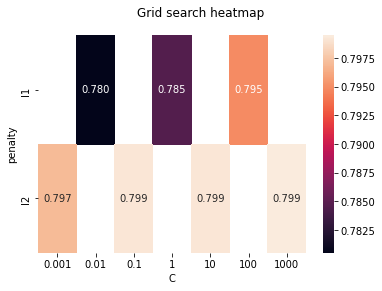

In [148]:
# code from the practical Exercise for Logistic Regression

grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
clf_lr = LogisticRegression(class_weight='balanced', dual=False, 
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          n_jobs=1, random_state=0, tol=0.0001, verbose=0, warm_start=False)

gs_lr = GridSearchCV(clf_lr, grid_lr, return_train_score=True, cv=4) 

gs_lr.fit(X_train, y_train)

best_score_lr, clf_lr = plot_2d_grid_search_heatmap(gs_lr, grid_lr, 'C', 'penalty')

print("intercept_:")
print(clf_lr.intercept_ )
print()
print("coef_:")
print(clf_lr.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/lo


grid_search.best_score_:
0.8451008645533141

grid_search.best_estimator_:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


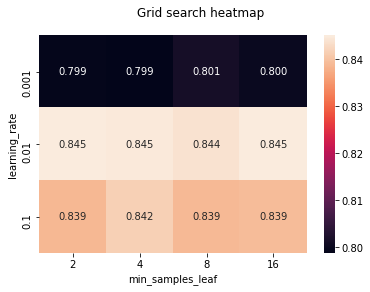

In [149]:
# code from the practical Exercise for Logistic Regression

grid_gb = {'min_samples_leaf': [2, 4, 8, 16], 'learning_rate': [0.001, 0.01, 0.1]}

clf_gbm = GradientBoostingClassifier(criterion='friedman_mse',
              init=None, loss='deviance', max_features='sqrt', max_leaf_nodes=None, 
              max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=800,
              presort='auto', random_state=0, subsample=1.0, verbose=0, warm_start=False)

gs_gb = GridSearchCV(clf_gbm, grid_gb, verbose=0, return_train_score=True, cv=4)

gs_gb.fit(X_train, y_train)

best_score_gb, clf_gb = plot_2d_grid_search_heatmap(gs_gb, grid_gb, 'min_samples_leaf', 'learning_rate')


grid_search.best_score_:
0.8431796349663785

grid_search.best_estimator_:
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)


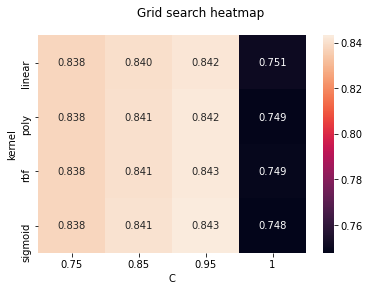

In [150]:
grid_sv = {'C': [0.75, 0.85, 0.95, 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
clf_sv = SVC(random_state=42, probability=True)

gs_sv = GridSearchCV(clf_sv, grid_sv, return_train_score=True, cv=4) 

gs_sv.fit(X_train, y_train)

best_score_sv, clf_sv = plot_2d_grid_search_heatmap(gs_sv, grid_sv, 'C', 'kernel')

In [151]:
# code based on the practical Exercise for Logistic Regression

li_clfs = ['clf_lr', 'clf_gb', 'clf_sv']
dfp = pd.DataFrame(index=['TARGET'], data=[y_test]).T

for s_clf in li_clfs:
    print("MODEL: " + s_clf)
    print("--------------")
    clf = eval(s_clf)
    
    y_pred = clf.predict(X_test).astype(int)  
    y_score = clf.predict_proba(X_test)  

    s_class = "%s_class" % s_clf
    s_proba = "%s_proba" % s_clf
    s_rank = "%s_rank" % s_clf
    
    dfp[s_class] = y_pred
    dfp[s_proba] = y_score[:,1]
    dfp[s_rank] = dfp[s_proba].rank(ascending=1).astype(int)
    
    cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predicted'], margins=True)
    print(cm) 
    
    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    
    if s_clf == 'clf_lr':
        y_score_lr = y_score.copy() 
    elif s_clf == 'clf_gb':
        y_score_gb = y_score.copy()
    else:
        print('Error')
        break

MODEL: clf_lr
--------------
Predicted    0    1   All
Reality                  
0          198   59   257
1          150  635   785
All        348  694  1042

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.77      0.65       257
           1       0.91      0.81      0.86       785

    accuracy                           0.80      1042
   macro avg       0.74      0.79      0.76      1042
weighted avg       0.83      0.80      0.81      1042

MODEL: clf_gb
--------------
Predicted    0    1   All
Reality                  
0          114  143   257
1           27  758   785
All        141  901  1042

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.44      0.57       257
           1       0.84      0.97      0.90       785

    accuracy                           0.84      1042
   macro avg       0.82      0.70      0.74      1042
weighted avg       0.83      0.84  

MODEL: clf_lr
--------------


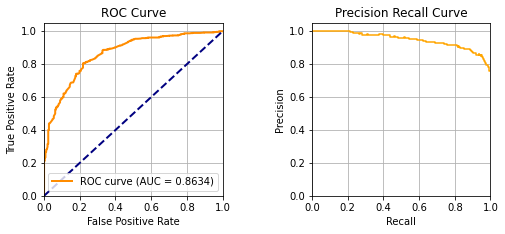


MODEL: clf_gb
--------------


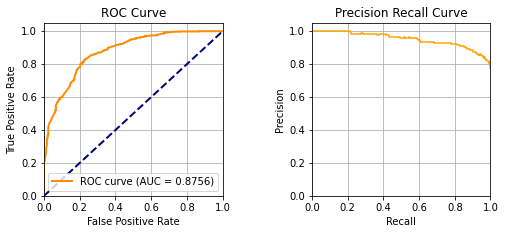


MODEL: clf_sv
--------------


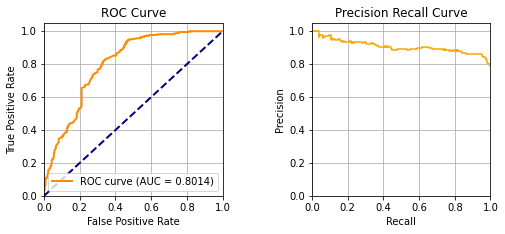

In [152]:
# code from the practical Exercise for Logistic Regression

def plot_roc_and_precision_recall(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score)

  roc_auc = auc(fpr, tpr)

  precision, recall, _ = precision_recall_curve(y_true, y_score)

  plt.figure(figsize=(8, 3))

  plt.subplot(1,2,1)
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.grid(True)

  plt.subplot(1,2,2)
  plt.step(recall, precision, color='orange', where='post')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision Recall Curve')
  plt.grid(True)

  left  = 0.125  
  right = 0.9   
  bottom = 0.1   
  top = 0.9      
  wspace = 0.5   
  hspace = 0.2   
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
  plt.show()

  
for s_clf in li_clfs:
    print("MODEL: " + s_clf)
    print("--------------")
    clf = eval(s_clf)
    
    y_pred = clf.predict(X_test).astype(int)
    y_score = clf.predict_proba(X_test)
    
    plot_roc_and_precision_recall(y_test, y_score[:,1])  
    print()
    